In [9]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
import os
import numpy as np
#from sklearn.mixture import GaussianMixture
import matplotlib.ticker as plticker
import pybedtools
import os
import os.path
import pandas as pd


## Classify samples as having ecDNA-chromothripsis (the ecDNA and chromothripsis samples overlap) or ecDNA, no chromothripsis (the events are distinct do not overlap) ##

In [65]:
ns = pd.read_table("/Users/azhark/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/ecDNA-chromothripsis/ecDNA-chromothripsis-summary_nonsmoker_intersection.tsv")
s = pd.read_table("/Users/azhark/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/ecDNA-chromothripsis/ecDNA-chromothripsis-summary_smoker_intersection.tsv")

#stack dataframes on top of each other
aa_merged = pd.concat([ns, s], axis=0)

barcode = []
aa_merged = pd.read_table("/Users/azhark/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/ecDNA-chromothripsis/ecDNA-chromothripsis-summary_all_intersection.tsv", sep="\t")
for s in aa_merged['ID']:
    barcode.append(s.split('_')[0])

aa_merged['Sample'] = barcode

aa_merged['Annotation'] = aa_merged['Annotation'].astype('category')
aa_merged['Annotation'] = aa_merged['Annotation'].cat.set_categories(["ecDNA, chromothripsis", "ecDNA, no chromothripsis"], ordered=True)
aa_merged.sort_values(by=["Sample", 'Annotation'], inplace=True, ascending=True)
aa_merged = aa_merged.drop_duplicates(subset=["Sample"]) #now we are at the sample level
aa_merged.head()


#NOW WE"RE AT THE SAMPLE LEVEL
result = aa_merged[["Sample", "overlap", "Annotation", "length_chromothripsis", "length_ecDNA"]]

#replace NaN with 0
result = result.fillna(0)
#output to tsv
result.to_csv("/Users/azhark/iCloud/dev/Sherlock-Lung/results2/ecDNA-chromothripsis.txt", sep="\t", index=False)


,ID,length_ecDNA,overlap,length_chromothripsis,Annotation,Sample
0,AEIUFAVJ_amplicon4_ecDNA_1_intervals,15776,0.0,NaN,"ecDNA, no chromothripsis",AEIUFAVJ
1,E01014101_amplicon1_ecDNA_1_intervals,1044237,0.0,0.0,"ecDNA, no chromothripsis",E01014101
2,EBUS110413B_amplicon2_ecDNA_1_intervals,6178570,6178570.0,18857004.0,"ecDNA, chromothripsis",EBUS110413B
4,NSLC-AI82-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,1611524,1611524.0,54653300.0,"ecDNA, chromothripsis",NSLC-AI82-TTP1-A-1-1-D-A77N-36
6,NSLC-AI83-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,826186,826186.0,36670481.0,"ecDNA, chromothripsis",NSLC-AI83-TTP1-A-1-1-D-A77N-36


In [52]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 48
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Sample                 131 non-null    object  
 1   overlap                131 non-null    float64 
 2   Annotation             131 non-null    category
 3   length_chromothripsis  131 non-null    float64 
 4   length_ecDNA           131 non-null    int64   
dtypes: category(1), float64(2), int64(1), object(1)
memory usage: 5.4+ KB


## Obtain set of overlapping samples #

In [53]:
data = pd.read_table("~/iCloud/dev/Sherlock-Lung/results2/log-reg-table5.tsv", sep="\t")
#Select rows Smoking=="Smoker" & Histology=="Adenocarcinoma"

#data = data[(data["Smoking"]=="Smoker")]

chromo = data[data["Chromothripsis"] == 1]["Tumor_Barcode"]
ecDNA = data[data["ecDNA_status"] == 1]["Tumor_Barcode"]

intersection = set(chromo) & set(ecDNA)
len(intersection)


184

## Intersect ecDNA regions with chromothripsis regions and compute overlap ##

In [3]:
ecDNA_dir = "/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/ecDNA-regions/rescaled/ecDNA"
sv_dir = "/Users/khandekara2/iCloud/dev/Sherlock-Lung/data/ShatterSeek-input/output/"
genome_file = "/Users/khandekara2/iCloud/dev/Sherlock-Lung/data/ShatterSeek-input/SV/GRCh38.genome"

metadata = pd.read_csv("/Users/khandekara2/iCloud/dev/Sherlock-Lung/metadata/wgs_data_full_all_1217_final.txt", sep="\t")
mapping = dict(zip(metadata["Tumor_Sample_ID"], metadata["Tumor_Barcode"]))

os.chdir("/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/ecDNA-regions/rescaled/ecDNA")

# Convert the chromosome part to numeric while keeping 'X', 'Y', and 'MT' intact (if present)
# Sorting chromosomes with numbers first, followed by 'X', 'Y', and 'MT'
def custom_sort_key(chrom):
    try:
        # Return numeric for chromosomes like chr1, chr2, etc.
        return int(chrom)
    except ValueError:
        # Handle special cases like chrX, chrY, and chrM (or chrMT)
        if chrom == 'X':
            return 23
        elif chrom == 'Y':
            return 24
        elif chrom == 'M' or chrom == 'MT':
            return 25
        else:
            return 100  # Default for any other potential chromosomes

for file in os.listdir("."):
    
    ecDNA = pd.read_csv(file, sep="\t", header=None)
    sample = file.split(".")[0]
    
    #if file exists in chromothripsis directory
    #check if file exists
    if sample not in mapping or not os.path.exists("/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/" + mapping[sample] + "_chromothripsis.tsv"):
        print(sample)
        continue
        # os.chdir("/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/")
        # for f in os.listdir("/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/"):
        #     if sample in f:
        #         sv = pd.read_csv(f, sep="\t")
        #         if sv.shape[1] >= 1:
        #             sv["chrom"] = sv["chrom"].astype(int)
        #             sv["start"] = sv["start"].astype(int)
        #             sv["end"] = sv["end"].astype(int)
        #             sv = sv.sort_values(by=['chrom', 'start'], key=lambda x: x.map(custom_sort_key))
        #             sv[sv.columns[0]] = "chr" + sv[sv.columns[0]].astype(str)
                    
        #             chromo_file = "/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/" + sample + "_chromothripsis.tsv"
        #             a = pybedtools.BedTool(file) #ecDNA
        #             b = pybedtools.BedTool.from_dataframe(sv) #chromothripsis region

        #             #wao- Write the original A and B entries plus the number of base pairs of overlap between the two features.
        #             #However, A features w/o overlap are also reported with a NULL B feature and overlap = 0.
        #             c = a.intersect(b, wao=True, g=genome_file)

    else:
        print("Found: " + "/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/" + mapping[sample] + "_chromothripsis.tsv")
        sv = pd.read_csv("/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/" + mapping[sample] + "_chromothripsis.tsv", sep="\t")
        if sv.shape[1] >= 1:
            sv["chrom"] = sv["chrom"].astype(int)
            sv["start"] = sv["start"].astype(int)
            sv["end"] = sv["end"].astype(int)
            sv = sv.sort_values(by=['chrom', 'start'], key=lambda x: x.map(custom_sort_key))
            sv[sv.columns[0]] = "chr" + sv[sv.columns[0]].astype(str)
            
            chromo_file = "/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/" + sample + "_chromothripsis.tsv"
            a = pybedtools.BedTool(file) #ecDNA
            b = pybedtools.BedTool.from_dataframe(sv) #chromothripsis region


            #wao- Write the original A and B entries plus the number of base pairs of overlap between the two features.
            #However, A features w/o overlap are also reported with a NULL B feature and overlap = 0.
            c = a.intersect(b, wao=True, g=genome_file)

            result_df = c.to_dataframe()
            result_df.columns = final.columns.tolist() + ["chrom1", "start1", "stop1", "Sample", "ID", "chrom2", "start2", "stop2", "Tumor_Barcode", "overlap"]
            result_df.to_csv("/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/ecDNA-chromothripsis/" + mapping[sample] + ".bed", sep="\t", index=False)
            #c.saveas("/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/ecDNA-regions/rescaled/ecDNA_chromothripsis/" + sample + "_ecDNA_chromothripsis.tsv")
            print("Saved: " + "/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/ecDNA-chromothripsis/" + mapping[sample] + ".bed")



Found: /Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/NSLC-0287-T01_chromothripsis.tsv


In [4]:
result_df.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr5,262687,682468,NSLC-AI90-TTP1-A-1-1-D-A77N-36,NSLC-AI90-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,chr5,41037,37174296,NSLC-0287-T01,419781
1,chr5,693167,1968299,NSLC-AI90-TTP1-A-1-1-D-A77N-36,NSLC-AI90-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,chr5,41037,37174296,NSLC-0287-T01,1275132
2,chr5,1971469,2561779,NSLC-AI90-TTP1-A-1-1-D-A77N-36,NSLC-AI90-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,chr5,41037,37174296,NSLC-0287-T01,590310
3,chr7,21371731,22396229,NSLC-AI90-TTP1-A-1-1-D-A77N-36,NSLC-AI90-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,chr7,677085,146838207,NSLC-0287-T01,1024498
4,chr7,85805118,87855889,NSLC-AI90-TTP1-A-1-1-D-A77N-36,NSLC-AI90-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,chr7,677085,146838207,NSLC-0287-T01,2050771


## LOOP THROUGH CHROMOTHRIPSIS AND ECDNA INTERSECTION FILES. EACH LINE IS A GENOMIC SEGMENT IN AN ECDNA. ##

In [61]:
l = []
os.chdir("/Users/azhark/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/ecDNA-chromothripsis")
for file in os.listdir("."):
    if file.endswith("_ecDNA-chromothripsis.bed"):
        sample = file.split("_")[0]
        if sample in intersection:
            print(sample)
            df = pd.read_csv(file, sep="\t")
            assert(len(df.columns) == 11)
            l.append(df)

master = pd.concat(l)

#fix the annotation here
#change annotation column to chromothripsis, no ecDNA if overlap == 0 and chromothripsis, ecDNA if overlap > 0
master["Annotation"] = np.where(master["overlap"] == 0, "ecDNA, no chromothripsis", "ecDNA, chromothripsis")
    

NSLC-0853-T01
NSLC-0543-T01
NSLC-0739-T01
NSLC-1187-T01
NSLC-0287-T01
NSLC-0558-T01
TCGA-86-8358-01A
NSLC-0358-T01
NSLC-0877-T01
NSLC-0567-T01
NSLC-1179-T01
NSLC-0279-T01
NSLC-0629-T01
NSLC-0632-T01
NSLC-0095-T01
NSLC-0330-T01
NSLC-0479-T01
NSLC-0889-T01
NSLC-0144-T01
NSLC-0514-T01
TCGA-44-7669-01A
NSLC-0317-T01
NSLC-0178-T01
NSLC-0624-T01
NSLC-0274-T01
NSLC-0752-T01
NSLC-0394-T01
NSLC-0807-T01
NSLC-0250-T01
TCGA-64-5779-01A
NSLC-0423-T01
NSLC-0551-T02
NSLC-0721-T01
NSLC-1071-T01
NSLC-0850-T01
NSLC-0673-T01
NSLC-0994-T01
NSLC-1136-T01
TCGA-55-A4DF-01A
TCGA-86-8673-01A
TCGA-86-7954-01A
NSLC-0613-T01
NSLC-0882-T01
NSLC-0962-T01
TCGA-38-4630-01A
NSLC-0320-T01
NSLC-0899-T01
NSLC-0535-T01
NSLC-0953-T01
TCGA-91-6847-01A
NSLC-1087-T01
NSLC-1229-T01
TCGA-55-8301-01A
NSLC-0044-T01
NSLC-0299-T01
NSLC-0546-T01
NSLC-1077-T01
NSLC-0282-T01
NSLC-0350-T01
NSLC-0481-T01
NSLC-1126-T01
NSLC-0561-T01
NSLC-0076-T01
NSLC-0078-T01
NSLC-1061-T01
NSLC-0545-T01
NSLC-0115-T01
NSLC-0374-T01
NSLC-0323-T01
NSLC-01

In [20]:
master

,chrom1,start1,stop1,Sample,ID,chrom2,start2,stop2,Tumor_Barcode,overlap,Annotation
0,chrY,15745853,15905537,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon7_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
1,chrY,15915997,15926972,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon7_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
2,chr10,28798912,28849240,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon6_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
3,chr10,28914651,28954735,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon6_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
4,chr10,29190022,29291069,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon6_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
...,...,...,...,...,...,...,...,...,...,...,...
1,chr12,67668551,70201084,NSLC-AJG6-TTP1-A-1-1-D-A79F-36,NSLC-AJG6-TTP1-A-1-1-D-A79F-36_amplicon1_ecDNA...,chr12,67109493.0,92948793.0,NSLC-0396-T01,2532533.0,"ecDNA, chromothripsis"
2,chr12,70203883,71962838,NSLC-AJG6-TTP1-A-1-1-D-A79F-36,NSLC-AJG6-TTP1-A-1-1-D-A79F-36_amplicon1_ecDNA...,chr12,67109493.0,92948793.0,NSLC-0396-T01,1758955.0,"ecDNA, chromothripsis"
3,chr12,71964349,77990098,NSLC-AJG6-TTP1-A-1-1-D-A79F-36,NSLC-AJG6-TTP1-A-1-1-D-A79F-36_amplicon1_ecDNA...,chr12,67109493.0,92948793.0,NSLC-0396-T01,6025749.0,"ecDNA, chromothripsis"
4,chr12,77990106,79163044,NSLC-AJG6-TTP1-A-1-1-D-A79F-36,NSLC-AJG6-TTP1-A-1-1-D-A79F-36_amplicon1_ecDNA...,chr12,67109493.0,92948793.0,NSLC-0396-T01,1172938.0,"ecDNA, chromothripsis"


In [37]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 0
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   chrom1         106 non-null    object 
 1   start1         106 non-null    int64  
 2   stop1          106 non-null    int64  
 3   Sample         106 non-null    object 
 4   ID             106 non-null    object 
 5   chrom2         84 non-null     object 
 6   start2         84 non-null     float64
 7   stop2          84 non-null     float64
 8   Tumor_Barcode  84 non-null     object 
 9   overlap        106 non-null    float64
 10  Annotation     106 non-null    object 
dtypes: float64(3), int64(2), object(6)
memory usage: 9.9+ KB


In [38]:
#convert columns to type int
master["start1"] = master["start1"].astype(int)
master["stop1"] = master["stop1"].astype(int)
# master["start2"] = master["start2"].astype(int)
# master["stop2"] = master["stop2"].astype(int)

In [16]:
list(master["start1"])

[15745853,
 15915997,
 28798912,
 28914651,
 29190022,
 29341595,
 30970500,
 33340389,
 38995007,
 39230136,
 39252571,
 39267936,
 51400802,
 57452624,
 58629515,
 60131254,
 66351034,
 70203797,
 71210693,
 71796969,
 71964387,
 74028829,
 74274479,
 53438049,
 32077810,
 56754556,
 56941547,
 56991437,
 57539428,
 57600821,
 57620614,
 57648636,
 58894470,
 59519287,
 59641512,
 59701584,
 59868273,
 59876900,
 60212576,
 60233542,
 60625607,
 61663670,
 62280786,
 62842179,
 63895198,
 57702294,
 59543034,
 59627550,
 64310744,
 65293976,
 67832021,
 68299255,
 68321991,
 68617801,
 69385410,
 69462250,
 'start',
 '682337',
 '866150',
 '1628726',
 '1971469',
 '8416876',
 '8465325',
 '8468031',
 '9474510',
 '13337559',
 'start',
 '683690',
 '750405',
 '776188',
 '840046',
 46135409,
 46258871,
 46282210,
 64922331,
 262687,
 693167,
 1971469,
 21371731,
 85805118,
 69071971,
 81786239,
 20116145,
 20448924,
 24302484,
 36708276,
 23047824,
 25221900,
 29067064,
 29869546,
 30328056

In [18]:
s = master[master["start1"] == "start"]

In [19]:
s.head()

,chrom1,start1,stop1,Sample,ID,chrom2,start2,stop2,Tumor_Barcode,overlap
0,#chr,start,stop,sample,ID,NaN,NaN,NaN,NaN,0.0
0,#chr,start,stop,sample,ID,NaN,NaN,NaN,NaN,0.0
0,#chr,start,stop,sample,ID,NaN,NaN,NaN,NaN,0.0
0,#chr,start,stop,sample,ID,NaN,NaN,NaN,NaN,0.0
0,#chr,start,stop,sample,ID,NaN,NaN,NaN,NaN,0.0


In [22]:
#d = master[master["overlap"] == 0]
d.head()

,chrom1,start1,stop1,Sample,ID,chrom2,start2,stop2,Tumor_Barcode,overlap
0,chrY,15745853,15905537,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon7_ecDNA...,.,-1.0,-1.0,.,0.0
1,chrY,15915997,15926972,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon7_ecDNA...,.,-1.0,-1.0,.,0.0
2,chr10,28798912,28849240,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon6_ecDNA...,.,-1.0,-1.0,.,0.0
3,chr10,28914651,28954735,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon6_ecDNA...,.,-1.0,-1.0,.,0.0
4,chr10,29190022,29291069,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon6_ecDNA...,.,-1.0,-1.0,.,0.0


In [39]:
master.head()

,chrom1,start1,stop1,Sample,ID,chrom2,start2,stop2,Tumor_Barcode,overlap,Annotation
0,chr17,46135409,46252353,SC033123,SC033123_amplicon1_ecDNA_1_intervals,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
1,chr17,46258871,46277790,SC033123,SC033123_amplicon1_ecDNA_1_intervals,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
2,chr17,46282210,46291987,SC033123,SC033123_amplicon1_ecDNA_1_intervals,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
3,chr17,64922331,64922515,SC033123,SC033123_amplicon1_ecDNA_1_intervals,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
0,chr18,12853480,13402609,TCGA-86-8358-01A,TCGA-86-8358-01A_amplicon2_ecDNA_1_intervals,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"


In [ ]:
length_ecDNA = master["stop1"] - master["start1"]
length_chromothripsis = master["stop2"] - master["start2"]
# Use GroupBy() & compute sum on specific column
df2 = master.groupby('ID')['length_ecDNA'].sum()
#print("Get sum of the grouped data:\n", df2)


## LOOP THROUGH CHROMOTHRIPSIS FILES AND FIND ALL THE SAMPLES WITH CHROMOTHRIPSIS THAT DID NOT HAVE ECDNA AND WRITE OUT THAT TEN COLUMN TABLE ##

In [28]:
#NOW 
os.chdir("/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/")
ecDNA_path = "/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/ecDNA-regions/rescaled/ecDNA/"
all_dfs = []
for file in os.listdir("."):
    if file.endswith("_chromothripsis.tsv"):
        sample = file.split("_")[0]
        if not os.path.isfile(ecDNA_path + sample + ".bed"):
            if (sample in mapping) and (not os.path.isfile(ecDNA_path + mapping[sample] + ".bed")): #chromothripsis without ecDNA
                chromo_df = pd.read_csv(file, sep="\t")
                ecDNA_df = pd.DataFrame(np.nan, index=range(chromo_df.shape[0]), columns=["chrom1", "start1", "stop1", "Sample", "ID"])
                result_df = pd.concat([ecDNA_df, chromo_df], axis=1)
                result_df["overlap"] = [0 for x in range(result_df.shape[0])]
                result_df.columns = ["chrom1", "start1", "stop1", "Sample", "ID", "chrom2", "start2", "stop2", "Tumor_Barcode", "overlap"]
                result_df["Annotation"] = ["chromothripsis, no ecDNA" for x in range(result_df.shape[0])]
                all_dfs.append(result_df)

df = pd.concat(all_dfs)
df.head()

,chrom1,start1,stop1,Sample,ID,chrom2,start2,stop2,Tumor_Barcode,overlap,Annotation
0,NaN,NaN,NaN,NaN,NaN,8,28878264,53806662,TCGA-55-6979-01A,0.0,"chromothripsis, no ecDNA"
1,NaN,NaN,NaN,NaN,NaN,20,8770894,26312807,TCGA-55-6979-01A,0.0,"chromothripsis, no ecDNA"
0,NaN,NaN,NaN,NaN,NaN,19,14490031,44833120,TCGA-55-8510-01A,0.0,"chromothripsis, no ecDNA"
0,NaN,NaN,NaN,NaN,NaN,2,139096216,183010965,TCGA-78-7152-01A,0.0,"chromothripsis, no ecDNA"
1,NaN,NaN,NaN,NaN,NaN,5,98563395,149469400,TCGA-78-7152-01A,0.0,"chromothripsis, no ecDNA"


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 0
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   chrom1         0 non-null      float64
 1   start1         0 non-null      float64
 2   stop1          0 non-null      float64
 3   Sample         0 non-null      float64
 4   ID             0 non-null      float64
 5   chrom2         116 non-null    object 
 6   start2         116 non-null    object 
 7   stop2          116 non-null    object 
 8   Tumor_Barcode  116 non-null    object 
 9   overlap        116 non-null    float64
dtypes: float64(6), object(4)
memory usage: 10.0+ KB


In [85]:
master = pd.read_csv("/Users/khandekara2/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/ecDNA-chromothripsis/ecDNA-chromothripsis-master-table.tsv", sep="\t")
master.head()

,chrom1,start1,stop1,Sample,ID,chrom2,start2,stop2,Tumor_Barcode,overlap,Annotation
0,chrY,15745853.0,15905537.0,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon7_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
1,chrY,15915997.0,15926972.0,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon7_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
2,chr10,28798912.0,28849240.0,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon6_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
3,chr10,28914651.0,28954735.0,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon6_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"
4,chr10,29190022.0,29291069.0,NSLC-AKRF-TTP1-A-1-1-D-A81H-36,NSLC-AKRF-TTP1-A-1-1-D-A81H-36_amplicon6_ecDNA...,.,-1.0,-1.0,.,0.0,"ecDNA, chromothripsis"


In [86]:
#change the NaN values in start1 and stop1 to 0
master["start1"] = master["start1"].fillna(0)
master["stop1"] = master["stop1"].fillna(0)

In [87]:
master.Sample.nunique()

219

In [88]:
#randomly generate a string ID and replace the NAs in the ID column
import random
import string
def generate_random_id(length=10):
    """Generate a random string ID of specified length."""
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=length))

# Assuming df is your dataframe:
def fill_na_ids(df):
    """Fill NA values in ID column with random strings."""
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Find NA locations
    na_mask = df['ID'].isna()
    
    # Generate unique random IDs for each NA
    na_count = na_mask.sum()
    if na_count > 0:
        print(f"Filling {na_count} NA values with random IDs")
        random_ids = [generate_random_id() for _ in range(na_count)]
        
        # Fill NA values
        df.loc[na_mask, 'ID'] = random_ids
    
    return df

# Example usage:
master = fill_na_ids(master)


Filling 116 NA values with random IDs


In [89]:
master.isnull().sum(axis = 0)

chrom1           116
start1             0
stop1              0
Sample           116
ID                 0
chrom2           663
start2           663
stop2            663
Tumor_Barcode    663
overlap            0
Annotation         0
dtype: int64

In [90]:
master.Annotation.value_counts()

ecDNA, chromothripsis       840
ecDNA, no chromothripsis    663
chromothripsis, no ecDNA    116
Name: Annotation, dtype: int64

In [91]:
c = master[master["Annotation"] == "chromothripsis, no ecDNA"]
c.head()

,chrom1,start1,stop1,Sample,ID,chrom2,start2,stop2,Tumor_Barcode,overlap,Annotation
1503,NaN,0.0,0.0,NaN,I9QNOLUML8,8,28878264.0,53806662.0,TCGA-55-6979-01A,0.0,"chromothripsis, no ecDNA"
1504,NaN,0.0,0.0,NaN,J1KPL35RX2,20,8770894.0,26312807.0,TCGA-55-6979-01A,0.0,"chromothripsis, no ecDNA"
1505,NaN,0.0,0.0,NaN,R64V4LH38I,19,14490031.0,44833120.0,TCGA-55-8510-01A,0.0,"chromothripsis, no ecDNA"
1506,NaN,0.0,0.0,NaN,8WY4CTKDKK,2,139096216.0,183010965.0,TCGA-78-7152-01A,0.0,"chromothripsis, no ecDNA"
1507,NaN,0.0,0.0,NaN,UU3P9GSWHL,5,98563395.0,149469400.0,TCGA-78-7152-01A,0.0,"chromothripsis, no ecDNA"


## Here we perform a groupby operation to go from individual segments to ecDNA-level (each row represents an ecDNA). ##

In [62]:
length_ecDNA = master["stop1"] - master["start1"]
length_chromothripsis = master["stop2"] - master["start2"]
master["length_ecDNA"] = length_ecDNA
master["length_chromothripsis"] = length_chromothripsis

#get all rows where overlap is 
#master2 = 

result = master.groupby('ID').agg({
    'length_ecDNA': 'sum',
    'overlap': 'sum',
    'length_chromothripsis': 'median',
    "Annotation": lambda x: x.mode().iloc[0]
}).reset_index()

In [63]:
result.Annotation.value_counts(dropna=False)

ecDNA, no chromothripsis    175
ecDNA, chromothripsis        49
Name: Annotation, dtype: int64

In [32]:
result

,ID,length_ecDNA,overlap,length_chromothripsis,Annotation
0,NSLC-AI82-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,15380,0.0,0.0,"ecDNA, no chromothripsis"
1,NSLC-AI82-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,1611524,1611524.0,54653300.0,"ecDNA, chromothripsis"
2,NSLC-AI82-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,802990,802990.0,54653300.0,"ecDNA, chromothripsis"
3,NSLC-AI83-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,826186,826186.0,36670481.0,"ecDNA, chromothripsis"
4,NSLC-AI83-TTP1-A-1-1-D-A77N-36_amplicon1_ecDNA...,7730069,0.0,0.0,"ecDNA, no chromothripsis"
...,...,...,...,...,...
155,TCGA-50-6597-01A_amplicon1_ecDNA_1_intervals,6967801,2067771.0,0.0,"ecDNA, chromothripsis"
156,TCGA-50-6597-01A_amplicon1_ecDNA_2_intervals,47000,47000.0,42756776.0,"ecDNA, chromothripsis"
157,TCGA-50-6597-01A_amplicon1_ecDNA_3_intervals,62089,62089.0,42756776.0,"ecDNA, chromothripsis"
158,TCGA-50-6597-01A_amplicon1_ecDNA_4_intervals,189487,189487.0,42756776.0,"ecDNA, chromothripsis"


In [95]:
# if overlap is 0 and length chromothripsis is NaN, them multiply length ecDNA by -1
result.loc[(result["overlap"] == 0) & (result["length_chromothripsis"].isnull()), "length_ecDNA"] *= -1

In [96]:
#if the length chromothripsis is 0, change the Annotation to ecDNA, no chromothripsis
result.loc[result["length_chromothripsis"] == 0, "Annotation"] = "ecDNA, no chromothripsis"


In [64]:
#output to csv
#remove the string stem "_interval" from the ID column
#result["ID"] = result["ID"].str.replace("_interval", "")
result.to_csv("/Users/azhark/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/ecDNA-chromothripsis/ecDNA-chromothripsis-summary_all_intersection.tsv", sep="\t", index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#remove the string stem "_interval" from the ID

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_genomic_barplot(data, bar_height=0.4):
    """
    Create a horizontal bar plot showing ecDNA and chromothripsis regions.
    """
    # Clean the data
    data = data.copy()
    
    # Convert lengths from base pairs to Mb
    for col in ['length_ecDNA', 'overlap', 'length_chromothripsis']:
        data[col] = data[col].fillna(0) / 1e6
    
    # Create categories
    def get_category(row):
        if row['overlap'] > 0:
            return 1  # overlap category (highest priority)
        elif row['length_ecDNA'] > 0:
            return 2  # chromothripsis only
        else:
            return 3  # ecDNA only
            
    data['category'] = data.apply(get_category, axis=1)
    
    # Within each category, sort by the appropriate size:
    # - For overlap category: sort by chromothripsis size
    # - For chromothripsis only: sort by chromothripsis size
    # - For ecDNA only: sort by ecDNA size
    def get_sort_size(row):
        if row['category'] in [1, 2]:  # overlap or chromothripsis only
            return row['length_chromothripsis']
        else:  # ecDNA only
            return abs(row['length_ecDNA'])
            
    data['sort_size'] = data.apply(get_sort_size, axis=1)
    
    # Sort first by category, then by the appropriate size within each category
    data = data.sort_values(['category', 'sort_size'], 
                          ascending=[True, False])
    
    # Calculate figure size
    num_samples = len(data)
    fig_height = num_samples * 0.25  # 0.25 inch per sample
    figsize = (15, fig_height)
    
    # Set up clean style manually
    plt.style.use('default')
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    plt.rcParams['grid.color'] = '#cccccc'
    
    # Create figure with exact dimensions needed
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0.1, 0.1, 0.7, 0.85])
    
    # Calculate positions for bars
    positions = range(len(data))
    
    # Plot chromothripsis regions (light blue)
    chromothripsis_mask = data['length_chromothripsis'] > 0
    if chromothripsis_mask.any():
        ax.barh(
            y=[pos for pos, mask in zip(positions, chromothripsis_mask) if mask],
            width=data[chromothripsis_mask]['length_chromothripsis'],
            height=bar_height,
            label='Chromothripsis',
            color='#87CEEB',
            alpha=0.9
        )
    
    # Plot overlapping regions (red)
    overlap_mask = data['overlap'] > 0
    if overlap_mask.any():
        ax.barh(
            y=[pos for pos, mask in zip(positions, overlap_mask) if mask],
            width=data[overlap_mask]['overlap'],
            height=bar_height,
            label='ecDNA + Chromothripsis overlap',
            color='#FF6B6B',
            alpha=0.9
        )
    
    # Plot ecDNA-only regions (purple, negative direction)
    ecdna_only_mask = data['length_ecDNA'] < 0
    if ecdna_only_mask.any():
        ax.barh(
            y=[pos for pos, mask in zip(positions, ecdna_only_mask) if mask],
            width=abs(data[ecdna_only_mask]['length_ecDNA']),
            height=bar_height,
            label='ecDNA without Chromothripsis',
            color='#6A4C93',
            alpha=0.9,
            left=-abs(data[ecdna_only_mask]['length_ecDNA'])
        )
    
    # Plot ecDNA regions with chromothripsis but no overlap (light blue)
    ecdna_chromo_no_overlap = (data['length_ecDNA'] > 0) & (data['overlap'] == 0)
    if ecdna_chromo_no_overlap.any():
        ax.barh(
            y=[pos for pos, mask in zip(positions, ecdna_chromo_no_overlap) if mask],
            width=data[ecdna_chromo_no_overlap]['length_ecDNA'],
            height=bar_height,
            label='ecDNA (no overlap)',
            color='#87CEEB',
            alpha=0.9
        )
    
    # Customize plot
    ax.set_yticks(positions)
    ax.set_yticklabels(data['ID'], fontsize=6)
    
    # Set y-axis limits explicitly
    ax.set_ylim(len(data) - 0.5, -0.5)
    
    # Add vertical line at x=0
    ax.axvline(x=0, color='black', linewidth=0.5)
    
    # Set x-axis limits to be symmetric
    max_abs_x = max(
        abs(data['length_ecDNA'].min()),
        abs(data['length_chromothripsis'].max())
    )
    ax.set_xlim(-max_abs_x * 1.1, max_abs_x * 1.1)
    
    # Customize layout
    ax.set_xlabel('Size of region (Mb)')
    ax.set_title('ecDNA and Chromothripsis Regions by Sample', pad=20)
    
    # Add legend with adjusted position
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add summary statistics
    stats_text = (
        f"Total samples: {len(data)}\n"
        f"Samples with overlap: {(data['category'] == 1).sum()}\n"
        f"Chromothripsis only: {(data['category'] == 2).sum()}\n"
        f"ecDNA only: {(data['category'] == 3).sum()}\n"
        f"Average ecDNA size: {abs(data['length_ecDNA']).mean():.1f} Mb"
    )
    
    plt.figtext(0.98, 0.5, stats_text, 
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='center')
    
    return fig, ax

# Example usage with your data
# Assuming the data is in a string format, we'll use StringIO to read it
from io import StringIO


# Read and process the data
#df = pd.read_csv('your_data.csv', sep='\t')

# Create plot
fig, ax = create_genomic_barplot(result)
plt.show()


In [ ]:
#out

In [52]:
df = result
# Convert lengths to Mb and look at value distributions
print("Number of total rows:", len(df))
print("\nNumber of rows with non-zero values:")
print("length_ecDNA:", (df['length_ecDNA'] != 0).sum())
print("overlap:", (df['overlap'] != 0).sum())
print("length_chromothripsis:", (df['length_chromothripsis'].notna()).sum())

# Look at the last 10 rows of the data to see what's there
print("\nLast 10 rows of the data:")
print(df.tail(10)[['ID', 'length_ecDNA', 'overlap', 'length_chromothripsis', 'Annotation']])

# Check for any NaN or null values
print("\nNumber of NaN values in each column:")
print(df.isna().sum())


Number of total rows: 342

Number of rows with non-zero values:
length_ecDNA: 342
overlap: 56
length_chromothripsis: 191

Last 10 rows of the data:
                                       ID  length_ecDNA  overlap  \
332   TCGA-86-8358-01A_amplicon2_ecDNA_1s      549129.0      0.0   
333   TCGA-86-8585-01A_amplicon2_ecDNA_1s      195088.0      0.0   
334   TCGA-86-8673-01A_amplicon4_ecDNA_1s      100970.0      0.0   
335   TCGA-86-8673-01A_amplicon6_ecDNA_1s       85364.0      0.0   
336   TCGA-86-8673-01A_amplicon7_ecDNA_1s      129819.0      0.0   
337   TCGA-91-6847-01A_amplicon1_ecDNA_1s     1856640.0      0.0   
338  TCGA-91-7771-01A_amplicon10_ecDNA_1s       61098.0      0.0   
339   TCGA-91-7771-01A_amplicon3_ecDNA_1s      105610.0      0.0   
340   TCGA-97-8174-01A_amplicon1_ecDNA_1s      -69192.0      0.0   
341   TCGA-MP-A4TA-01A_amplicon3_ecDNA_1s     -171050.0      0.0   

     length_chromothripsis                Annotation  
332                    0.0     ecDNA, chromothri

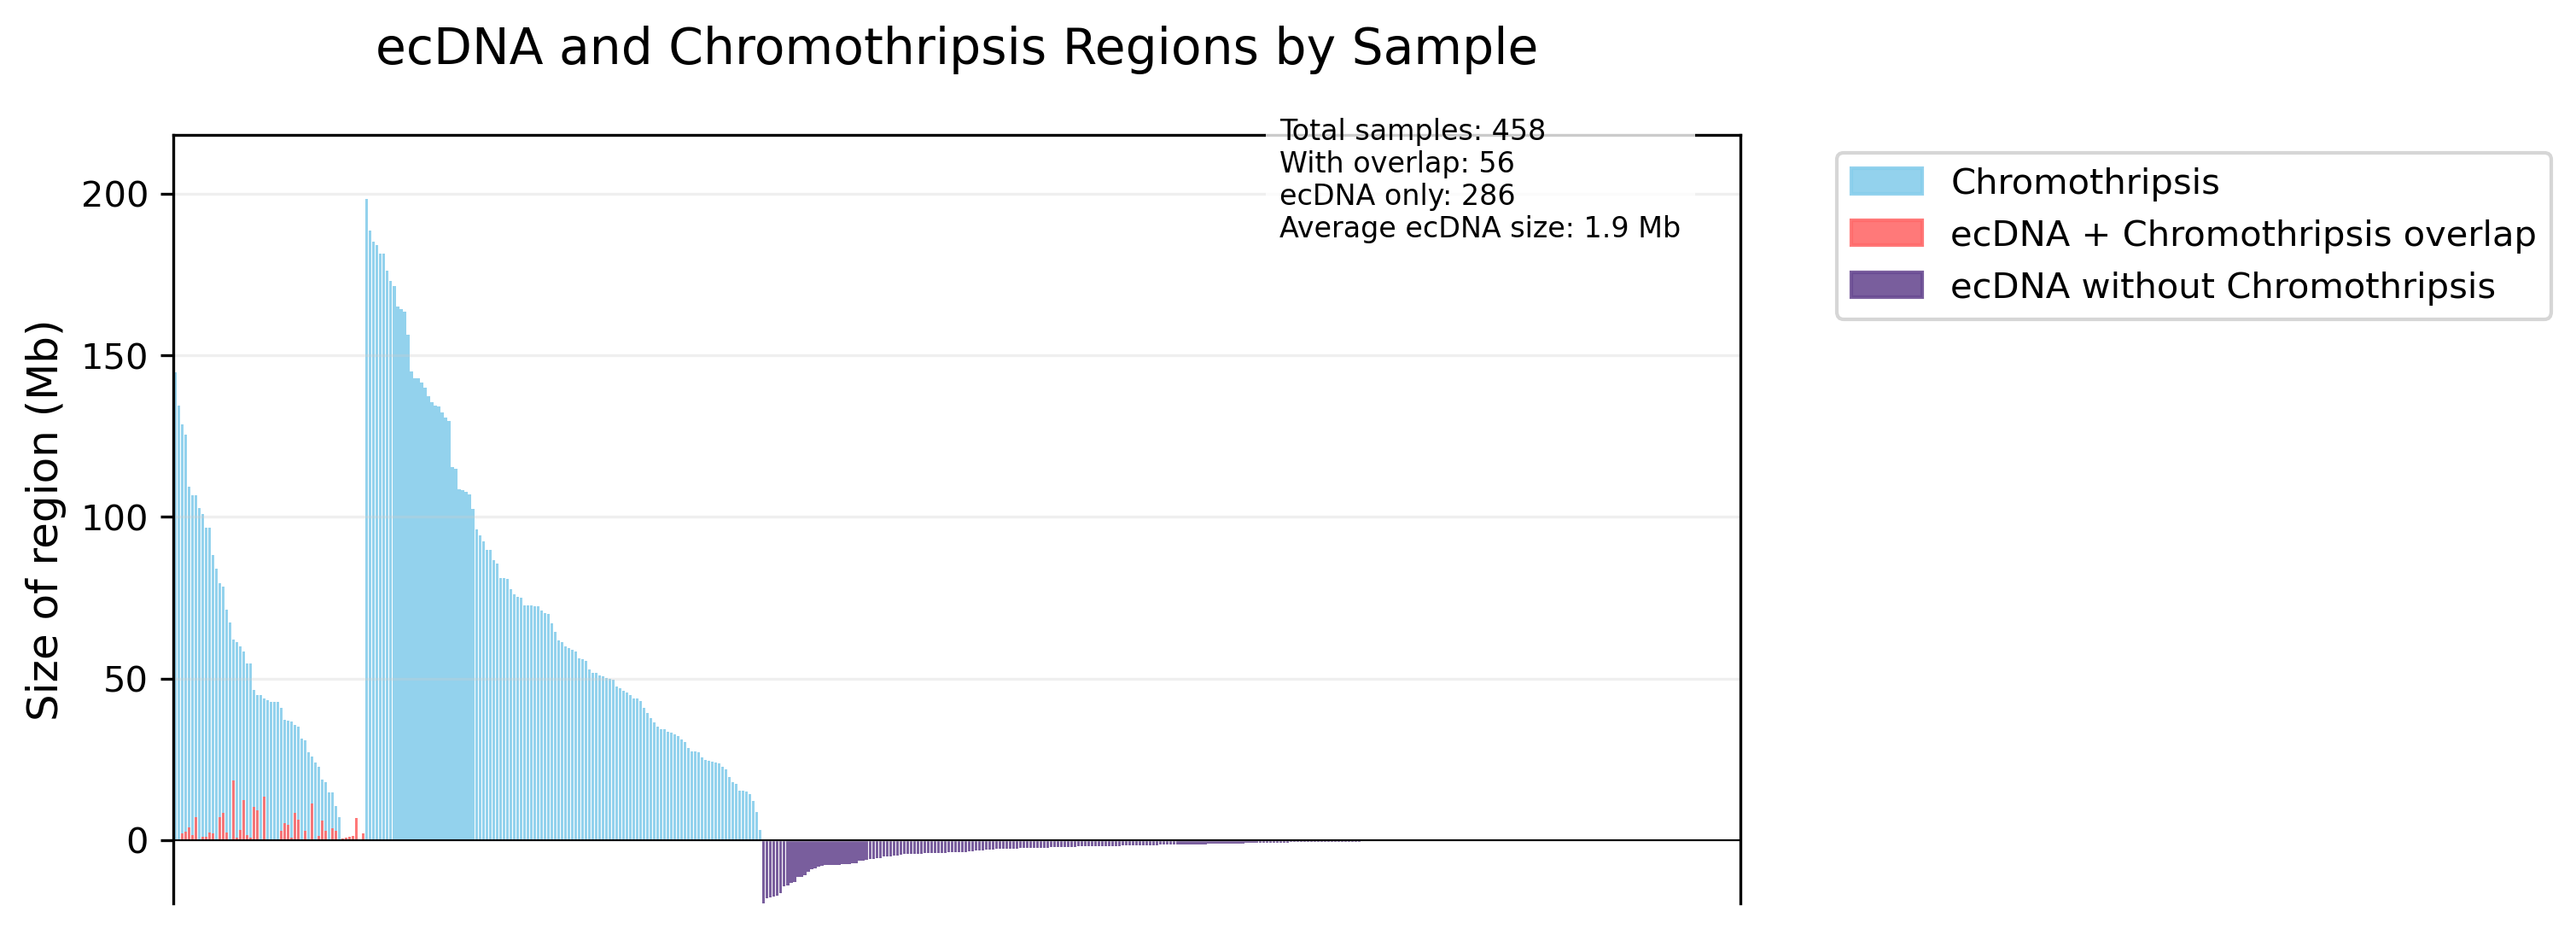

In [ ]:
def create_genomic_barplot(data, bar_width=0.8):  # Made bars wider
    """
    Create a vertical bar plot showing ecDNA and chromothripsis regions.
    """
    # Clean the data
    data = data.copy()
    
    # Convert lengths from base pairs to Mb
    for col in ['length_ecDNA', 'overlap', 'length_chromothripsis']:
        data[col] = data[col].fillna(0) / 1e6
    
    # Fix the categories based on overlap
    data['category'] = data['Annotation']
    data.loc[data['overlap'] > 0, 'category'] = 'ecDNA, chromothripsis'
    
    # Create sort order
    def get_sort_values(row):
        if row['overlap'] > 0:
            return (1, row['length_chromothripsis'])
        elif row['category'] == 'ecDNA, chromothripsis':
            return (2, row['length_chromothripsis'])
        elif row['category'] == 'chromothripsis, no ecDNA':
            return (3, row['length_chromothripsis'])
        else:  # ecDNA, no chromothripsis
            return (4, abs(row['length_ecDNA']))
    
    # Apply sorting
    data['sort_1'] = data.apply(lambda x: get_sort_values(x)[0], axis=1)
    data['sort_2'] = data.apply(lambda x: get_sort_values(x)[1], axis=1)
    data = data.sort_values(['sort_1', 'sort_2'], ascending=[True, False])
    
    # Calculate figure size based on number of samples
    num_samples = len(data)
    
    # Set up clean style manually
    plt.style.use('default')
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    plt.rcParams['grid.color'] = '#cccccc'

    # Adjust font sizes for publication
    plt.rcParams['font.size'] = 8  # base font size
    plt.rcParams['axes.labelsize'] = 8
    plt.rcParams['axes.titlesize'] = 9
    plt.rcParams['legend.fontsize'] = 8 
    
    # Publication-quality figure size (double column)
    fig = plt.figure(figsize=(7.2, 4), dpi=300)  # width=7.2 inches (183 mm), height adjusted for good aspect ratio
    ax = fig.add_axes([0.1, 0.15, 0.85, 0.75])  # Add this line here


    # Calculate positions for bars
    positions = range(len(data))
    
    # Plot bars
    for idx, row in data.iterrows():
        pos = data.index.get_loc(idx)
        
        if row['overlap'] > 0:
            ax.bar(pos, row['length_chromothripsis'], width=bar_width,
                  color='#87CEEB', alpha=0.9)
            ax.bar(pos, row['overlap'], width=bar_width,
                  color='#FF6B6B', alpha=0.9)
            
        elif row['category'] == 'ecDNA, chromothripsis':
            ax.bar(pos, row['length_chromothripsis'], width=bar_width,
                  color='#87CEEB', alpha=0.9)
            
        elif row['category'] == 'chromothripsis, no ecDNA':
            ax.bar(pos, row['length_chromothripsis'], width=bar_width,
                  color='#87CEEB', alpha=0.9)
            
        elif row['category'] == 'ecDNA, no chromothripsis':
            ax.bar(pos, -abs(row['length_ecDNA']), width=bar_width,
                  color='#6A4C93', alpha=0.9)
    
    # Customize plot
    ax.set_xticks(positions)
    #ax.set_xticklabels(data['ID'], fontsize=8, rotation=45, ha='right')  # Increased font size, adjusted rotation

    ax.set_xticks([])  # removes tick marks
    ax.spines['bottom'].set_visible(False)  # removes the bottom line of the plot
    
    # Set x-axis limits with some padding
    ax.set_xlim(-0.5, len(data) - 0.5)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linewidth=0.5)
    
    min_y = data['length_ecDNA'].min()  # actual minimum value
    max_y = data['length_chromothripsis'].max()  # actual maximum value
    ax.set_ylim(min_y * 1.1, max_y * 1.1)  # just add 10% padding on each end
    
    # Customize layout with larger fonts
    ax.set_ylabel('Size of region (Mb)', fontsize=12)
    ax.set_title('ecDNA and Chromothripsis Regions by Sample', pad=20, fontsize=14)
    ax.tick_params(axis='y', labelsize=10)  # Larger y-axis tick labels
    
    # Create legend with larger font
    handles = [
        plt.Rectangle((0,0),1,1, color='#87CEEB', alpha=0.9),
        plt.Rectangle((0,0),1,1, color='#FF6B6B', alpha=0.9),
        plt.Rectangle((0,0),1,1, color='#6A4C93', alpha=0.9)
    ]
    labels = ['Chromothripsis', 'ecDNA + Chromothripsis overlap', 'ecDNA without Chromothripsis']
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Add summary statistics with larger font
    stats_text = (
        f"Total samples: {len(data)}\n"
        f"With overlap: {(data['overlap'] > 0).sum()}\n"
        f"ecDNA only: {(data['category'] == 'ecDNA, no chromothripsis').sum()}\n"
        f"Average ecDNA size: {abs(data['length_ecDNA']).mean():.1f} Mb"
    )
    
    # Move stats box to better position for publication
    plt.figtext(0.7, 0.8, stats_text, 
           fontsize=8,
           bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    
    return fig, ax

result = pd.read_csv("~/iCloud/dev/Sherlock-Lung/results2/chromothripsis-regions/ecDNA-chromothripsis/ecDNA-chromothripsis-summary.tsv", sep="\t")
# Create plot
fig, ax = create_genomic_barplot(result)
plt.show()

#save figure as pdf 
#fig.savefig("/Users/khandekara2/iCloud/dev/Sherlock-Lung/figures/ecDNA-chromothripsis-regions.pdf", bbox_inches='tight', dpi=300)

In [5]:
result.head()

,ID,length_ecDNA,overlap,length_chromothripsis,Annotation
0,02SAATR90V,0.0,0.0,106950750.0,"chromothripsis, no ecDNA"
1,0EEBXWGDX4,0.0,0.0,23807193.0,"chromothripsis, no ecDNA"
2,0YXRCJD786,0.0,0.0,81143936.0,"chromothripsis, no ecDNA"
3,114_T_amplicon3_ecDNA_1,-2237330.0,0.0,NaN,"ecDNA, no chromothripsis"
4,16MH0041_P2_amplicon1_ecDNA_1,-48457.0,0.0,NaN,"ecDNA, no chromothripsis"


In [7]:
result.Annotation.value_counts()

ecDNA, no chromothripsis    293
chromothripsis, no ecDNA    116
ecDNA, chromothripsis        49
Name: Annotation, dtype: int64